In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geopy.distance import geodesic

In [ ]:
river_stations = pd.read_csv('output/rivers_stations_2002_2024.csv')

river_stations['geometry'] = gpd.points_from_xy(river_stations['lon'], river_stations['lat'])
river_stations = gpd.GeoDataFrame(river_stations, crs="EPSG:4326")
river_stations = river_stations.to_crs("EPSG:3035")
river_stations = river_stations[~river_stations['river'].str.contains('jezer', case=False)]


prec_stations = pd.read_csv('output/precipitation_stations_2002_2024.csv')
prec_stations['geometry'] = gpd.points_from_xy(prec_stations['lon'], prec_stations['lat'])
prec_stations = gpd.GeoDataFrame(prec_stations, crs="EPSG:4326")
prec_stations = prec_stations.to_crs("EPSG:3035")

weather_stations = pd.read_csv('output/weather_automatic_stations_2002-01-01_2024-07-23.csv')
weather_stations['geometry'] = gpd.points_from_xy(weather_stations['lon'], weather_stations['lat'])
weather_stations = gpd.GeoDataFrame(weather_stations, crs="EPSG:4326")
weather_stations = weather_stations.to_crs("EPSG:3035")

river_data = pd.read_csv('output/rivers_data_2002_2024.csv')
prec_data = pd.read_csv('output/precipitation_data_2002_2024.csv')


In [ ]:
prec_stations

In [ ]:
import ast

# Define a converter function to convert list-like strings to actual lists
def convert_to_list(value):
    return ast.literal_eval(value)

# Read the CSV file with converters for the list columns
close_river_prec = pd.read_csv('output/rivers_to_close_weather_stations.csv', converters={
    'precip_ids': convert_to_list,
    'precip_distances': convert_to_list
})


In [ ]:
import networkx as nx

G = nx.Graph()


In [ ]:
# filter out the prec stations where start_year = 2002, end_year = 2024
prec_stations = prec_stations[(prec_stations['start_year'] == 2002) & (prec_stations['end_year'] == 2024)]

In [ ]:
for r in river_stations.iterrows():
    G.add_node(f'r_{r[1]["id"]}', station_type='river', station_name=r[1]['name'], lat=r[1]['lat'], lon=r[1]['lon'])

In [ ]:
for p in prec_stations.iterrows():
    G.add_node(f"p_{p[1]['id']}", station_type='prec', station_name=p[1]['name'], lat=p[1]['lat'], lon=p[1]['lon'], alt=p[1]['alt'])

In [ ]:
close_river_prec.head()

In [ ]:
for _, c in close_river_prec.iterrows():
    r_id = c['id']
    
    if f"r_{r_id}" not in G.nodes:
        continue
    
    for i, p in enumerate(c['precip_ids']):
        if f"p_{p}" not in G.nodes:
            print(p)
            continue
        G.add_edge(f'r_{c["id"]}', f'p_{p}', dist=c['precip_distances'][i])

In [ ]:
# plot the graph, with the river stations in red and the precipitation stations in blue
# use pyvis to plot the graph

from pyvis.network import Network
import networkx as nx

nt = Network(height='100vh', width='100%', directed=False)
nt.from_nx(G)

# Set node colors based on type
for node in nt.nodes:
    node['color'] = 'blue' if node['station_type'] == 'river' else 'red'
    # add station_name to tooltip
    node['title'] = node['station_name']
    # add lat, lon to tooltip
    node['title'] += f"\nlat: {node['lat']}, lon: {node['lon']}"
    # add alt to tooltip
    if 'alt' in node:
        node['title'] += f"<br>alt: {node['alt']}"
        
    # add 
    
# add edge weight
for edge in nt.edges:
    edge['title'] = edge['dist']
    edge['width'] = min(edge['dist'], 10)  # You can scale this if needed
    # set edge color
    edge['color'] = 'gray'

nt.show("nx.html", notebook=False)


In [ ]:
danube_l = gpd.read_file('./euhydro/euhydro_danube_v013.gpkg', layer='River_Net_l')
po_l = gpd.read_file('./euhydro/euhydro_po_v013.gpkg', layer='River_Net_l')

In [ ]:
slovenia = gpd.read_file('SR.geojson')

In [ ]:
# danube_l = danube_l.to_crs("EPSG:3035")
# po_l = po_l.to_crs("EPSG:3035")
slovenia = slovenia.to_crs("EPSG:3035")

In [ ]:
slo_bb = slovenia.total_bounds
minx, miny, maxx, maxy = slo_bb
minx, miny = minx - 1e5, miny - 1e5
maxx, maxy = maxx + 1e5, maxy + 1e5

danube_l = danube_l.cx[minx:maxx, miny:maxy]
po_l = po_l.cx[minx:maxx, miny:maxy]

In [ ]:
# plot over slovenia
fig, ax = plt.subplots(figsize=(15, 15))

slovenia.plot(ax=ax, alpha=0.3, color='red')
danube_l.plot(ax=ax, alpha=0.5)
po_l.plot(ax=ax, alpha=0.5)

plt.show()

In [ ]:
def plot_over_slovenia(gdfs):
    fig, ax = plt.subplots(figsize=(15, 15))

    slovenia.plot(ax=ax, alpha=1.0, color='red')
    for gdf in gdfs:
        gdf.plot(ax=ax, alpha=0.5)

    plt.show()

In [ ]:
# plot over slovenia
fig, ax = plt.subplots(figsize=(15, 15))

slovenia.plot(ax=ax, alpha=0.3, color='red')
danube_l.plot(ax=ax, alpha=0.5)
po_l.plot(ax=ax, alpha=0.5)

plt.show()

In [ ]:
# for each river_station point geomtry find the cloest river geometry section mulitline z string

def find_closest_river_section(centroid, all_points, max_distance=10000):

    # Use spatial index to filter candidates
    possible_matches_index = list(all_points.sindex.query(centroid, predicate="dwithin", distance=max_distance))
    possible_matches = all_points.iloc[possible_matches_index]
    distances = possible_matches.distance(centroid)

    closest_points = distances.nsmallest(1)

    return closest_points.index.tolist(), closest_points.tolist()


rivers_m = pd.concat([danube_l, po_l])

river_stations_m = river_stations.copy()

rivers_m['centroid'] = rivers_m['geometry'].centroid

rivers_m.sindex
river_stations_m.sindex

closest_results = river_stations_m['geometry'].apply(lambda centroid: find_closest_river_section(centroid, rivers_m))

river_stations_m['closest_ids'], river_stations_m['distances'] = zip(*closest_results)

# handle also min() arg is an empty sequence
river_stations_m['closest_ids'] = river_stations_m['closest_ids'].apply(lambda x: x[0] if x else None)
river_stations_m['distances'] = river_stations_m['distances'].apply(lambda x: x[0] if x else None)

In [ ]:
river_stations_m

In [ ]:
river_stations_m[river_stations_m['distances'] > 60]

In [ ]:
# plot slovenia and single geometry

fig, ax = plt.subplots(figsize=(15, 15))

slovenia.plot(ax=ax, alpha=0.1, color='red')

river_stations_m.loc[12:12].plot(ax=ax, color='yellow', alpha=1)
rivers_m.loc[66698:66698].plot(ax=ax, alpha=1)

In [ ]:
closest_river_section_ids = river_stations_m['closest_ids'].tolist()




In [139]:
# for each river_section in rivers_m find the closest weather station

def find_closest_weather_stations(centroid, all_points, n_closest=5, max_distance=200000):
    
        # Use spatial index to filter candidates
        possible_matches_index = list(all_points.sindex.query(centroid, predicate="dwithin", distance=max_distance))
        possible_matches = all_points.iloc[possible_matches_index]
        distances = possible_matches.distance(centroid)
    
        closest_points = distances.nsmallest(n_closest)
    
        return closest_points.index.tolist(), closest_points.tolist()


weather_stations_x = weather_stations.copy()
weather_stations_x['centroid'] = weather_stations_x['geometry'].centroid

weather_stations_x.sindex

n_closest = 5
closest_results = rivers_m['geometry'].apply(lambda centroid: find_closest_weather_stations(centroid, weather_stations_x, n_closest))

rivers_m['closest_weather_ids'], rivers_m['distances'] = zip(*closest_results)

rivers_m['closest_weather_ids'] = rivers_m['closest_weather_ids'].apply(lambda x: x if x else None)

rivers_m = rivers_m[rivers_m['distances'].apply(lambda x: x[0] if x else 0) <= 30000]

# remove te river sections that have distances equal to nan
rivers_m = rivers_m[~rivers_m['distances'].isna()]
rivers_m = rivers_m[~rivers_m['closest_weather_ids'].isnull()]


<Axes: >

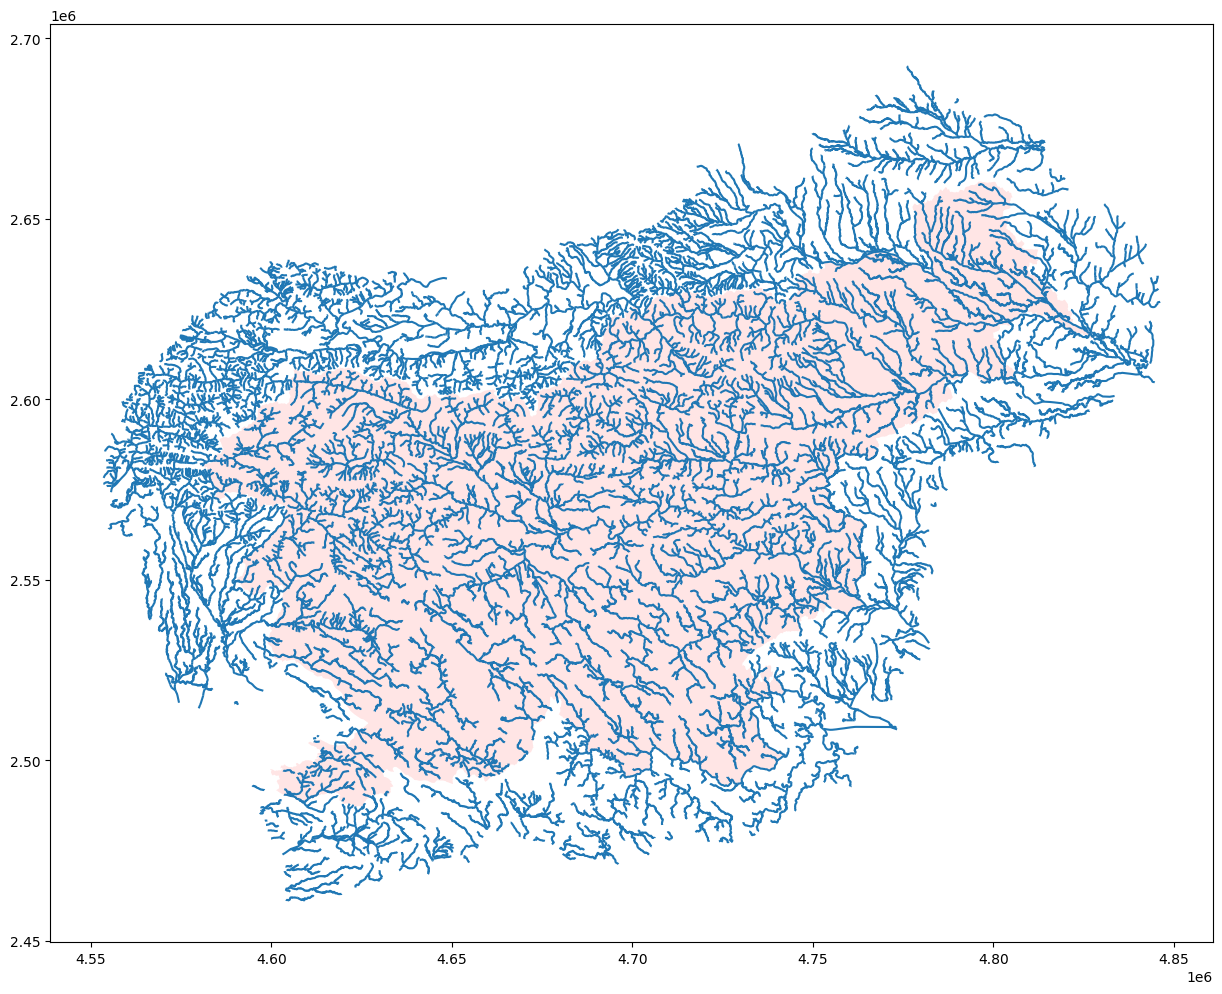

In [141]:
fig, ax = plt.subplots(figsize=(15, 15))

slovenia.plot(ax=ax, alpha=0.1, color='red')    
# rivers_m[rivers_m['closest_weather_ids'].isnull()].plot(ax=ax, alpha=1)

# plot the river sections where the closest weather station is null or smallest distance from distances column is > 200km

# rivers_m[rivers_m['closest_weather_ids'].isnull()].plot(ax=ax, alpha=1)


# plot river sections where smallest value from distances column is > 200km
# rivers_m[rivers_m['distances'].apply(lambda x: x[0] if x else 0) <= 30000].plot(ax=ax, alpha=1)

rivers_m.plot(ax=ax, alpha=1)